In [1]:
!pip install torch

import torch
import numpy as np

torch.manual_seed(1);

    100% |████████████████████████████████| 519.5MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59a50000 @  0x7fd338c831c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


Mount Google Drive for access to data

In [0]:
import sys
from google.colab import auth
import getpass

if sys.platform == 'linux' and not 'initialized' in locals():
  !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
  !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
  !apt-get update -qq 2>&1 > /dev/null
  !apt-get -y install -qq google-drive-ocamlfuse fuse
  
  auth.authenticate_user()
  from oauth2client.client import GoogleCredentials
  creds = GoogleCredentials.get_application_default()

  !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
  vcode = getpass.getpass()
  !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

  !mkdir -p data
  !google-drive-ocamlfuse data
  
  initialized = True
else:
  print("Already initialized")

Load model if it already exists

In [3]:
import os.path
MODEL_FNAME = 'data/models.data'

if os.path.isfile(MODEL_FNAME) and 'load_models' in locals() and load_models:
  with open('data/models.dat', 'rb') as f:
    train_res = pickle.load(f)
else:
  print("Not loading models")

Not loading models


Define global arguments

In [0]:
class args:
  # data set size
  train_size = 10000
  
  # training parameters
  print_every = 200
  plot_every = 100
 
  # sampling
  max_length = 255

Define the alphabet dictionary

In [0]:
from collections import defaultdict

# Define alphabet dictionary
next_index = 0
def get_new_index():
  global next_index
  index = next_index
  next_index += 1
  return index

alphabet = defaultdict(get_new_index)

# Data preprocessing

Load the phishing domains from a file. The file is expected to contain a pickled Python list of strings. Example:
```
first.domain.com
second.domain.com
third.domain.com
last.domain.com
```

In [0]:
import pickle

TRAIN_FILE = "data/phishing_domains.dat"
with open(TRAIN_FILE, 'rb') as f:
    data = pickle.load(f)  

Tokenize data and fill (reverse) alphabet

In [0]:
import itertools
import random

random.seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def tokenize(data):
  # Returns a list of Tensors, with each integer in the tensor representing a character in a domain name.
  # Note that domain names are case-insensitive.
  return [torch.tensor([alphabet['<s>']] + [alphabet[i] for i in domain.lower()] + [alphabet['</s>']]).to(device) for domain in data]

def detokenize(t):
  # Recreate domain name from tensor 1d t
  res = ''
  for token in t:
    res += reverse_alphabet[token.item()]
  return res

train_tokens = tokenize(data[:args.train_size])
  
alphabet_size = len(alphabet)
reverse_alphabet = dict([(v,k) for k, v in alphabet.items()])

random.shuffle(train_tokens)

Some helper functions for encoding domains and characters and rand

In [0]:
import numpy as np

def one_hot(d):
  # One-hot encoding of 1-d tensor d
  res = torch.zeros(len(d), 1, alphabet_size).to(device)
  for i, char in enumerate(d):
    res[i][0][int(char.item())] = 1
  return res

def encode_inputs(d):
  # One-hot encoding for the input of a 1d tensor
  return one_hot(d[:-1])

def encode_targets(d):
  # Return targets for 1d tensor d
  return d[1:]

Define model

# Training the model

In [0]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(RNNModel, self).__init__()              
        self.n_hidden = n_hidden

        self.i2h = nn.Linear(n_input + n_hidden, n_hidden)
        self.i2o = nn.Linear(n_input + n_hidden, n_output)
        self.o2o = nn.Linear(n_hidden + n_output, n_output)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden=None):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
      return torch.zeros(1, self.n_hidden).to(device)
    
lossfn = nn.NLLLoss()

Define train function, which trains a model on a single domain name

In [0]:
from torch.nn.utils import clip_grad_norm_

def train_example(model, optimizer, sample):
  # train on a single example domain name
  inputs, targets = encode_inputs(sample), encode_targets(sample)

  hidden = model.init_hidden()
  targets.unsqueeze_(-1)
 
  loss = 0
    
  for i in range(inputs.size(0)):    
    input, target = inputs[i], targets[i]
    output, hidden = model(input, hidden)
    loss += lossfn(output, target)   

  optimizer.zero_grad()
  loss.backward()
  clip_grad_norm_(model.parameters(), 0.5) # clip gradients to prevent explosion of loss
  optimizer.step()
    
  return output, loss.item()/inputs.size(0)   

Util function for timing

In [0]:
import time
import math

def elapsed(since):
  # Return a string representing the elapsed time since 'since'
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

def now():
  return time.time()

Train the model. The training function iterates over de training set and trains per domain name. The loss of all character predictions in the domain name is backpropagated.

In [0]:
def train(model, optimizer):
  print_loss, plot_loss, all_losses = 0, 0, []  
  start = now()

  for i, sample in enumerate(train_tokens):
    output, loss = train_example(model, optimizer, sample)
    print_loss += loss
    plot_loss += loss

    if (i+1) % args.print_every == 0:    
      avg_loss = print_loss / args.print_every
      print("%s (%d %d%%) %.4f" % (elapsed(start), i+1, (i+1)/args.train_size*100, avg_loss))
      print_loss = 0

    if (i+1) % args.plot_every == 0:
      avg_loss = plot_loss / args.plot_every
      all_losses.append(avg_loss)
      plot_loss = 0
      
  return all_losses

train_res = []

n_hidden = [256, 128]
learning_rates = [3e-3, 1e-3, 3e-4]
for n in n_hidden:
  for lr in learning_rates:
    print("Training with %d hidden nodes and a learning rate of %f" % (n, lr))
    model = RNNModel(alphabet_size, n, alphabet_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model_losses = train(model, optimizer)

    train_res.append((model, n, lr, model_losses))
   

Training with 256 hidden nodes and a learning rate of 0.003000
0m 14s (200 2%) 3.6412
0m 30s (400 4%) 2.7327
0m 44s (600 6%) 2.7290
0m 58s (800 8%) 2.7334
1m 13s (1000 10%) 2.6720
1m 28s (1200 12%) 2.6708
1m 44s (1400 14%) 2.6094
1m 58s (1600 16%) 11.7248
2m 13s (1800 18%) 2.7986
2m 27s (2000 20%) 2.5738
2m 42s (2200 22%) 2.6200
2m 56s (2400 24%) 2.5963
3m 12s (2600 26%) 2.6005
3m 27s (2800 28%) 2.5806
3m 42s (3000 30%) 2.5833
3m 57s (3200 32%) 2.6198
4m 11s (3400 34%) 2.6001
4m 26s (3600 36%) 2.6012
4m 41s (3800 38%) 2.5607
4m 56s (4000 40%) 2.6114
5m 11s (4200 42%) 2.6005
5m 26s (4400 44%) 2.5746
5m 41s (4600 46%) 2.5640
5m 54s (4800 48%) 2.5683
6m 8s (5000 50%) 295.9247
6m 23s (5200 52%) 2.5434
6m 38s (5400 54%) 2.5623
6m 52s (5600 56%) 2.6056
7m 6s (5800 57%) 2.5616
7m 19s (6000 60%) 2.6111
7m 33s (6200 62%) 2.5511
7m 48s (6400 64%) 2.5797
8m 2s (6600 66%) 2.5162
8m 17s (6800 68%) 2.5829
8m 32s (7000 70%) 2.6197
8m 46s (7200 72%) 2.6451
9m 1s (7400 74%) 2.5721
9m 14s (7600 76%) 2.7

In [1]:
if 'save_models' in locals() and save_models:
  with open(MODEL_FNAME, 'wb') as f:
    pickle.dump(train_res, f)
else:
  print("Model saving disabled. Use 'save_models = True' to enable model saving")

Model saving disabled. Use 'save_models = True' to enable model saving


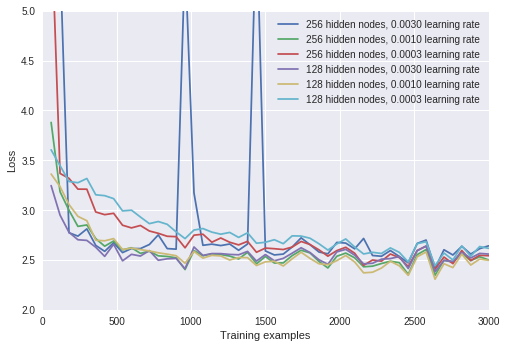

In [146]:
import matplotlib.pyplot as plt

plt.figure()
X = np.arange(0, args.train_size, args.plot_every)+args.plot_every
for model, n, lr, model_losses in train_res:
  line, = plt.plot(X, model_losses)
  line.set_label("%d hidden nodes, %.4f learning rate" % (n, lr))
plt.legend()
plt.ylim(2, 5)
plt.xlim(0, args.train_size)
plt.xlabel("Training examples")
plt.ylabel("Loss");

plt.savefig('parameter_optimization.eps')

# Domain name generation

Sample the network to generate domain names

In [149]:
def one_hot_letter(l):
  # One-hot encoding of letter
  return one_hot(torch.tensor([alphabet[l]]))[0]

def sample(model, start_letter='<s>'):
  with torch.no_grad():
    input = one_hot_letter(start_letter)
    hidden = model.init_hidden()   

    res = '' if start_letter == '<s>' else start_letter
    
    for i in range(args.max_length):   
      output, hidden = model(input, hidden)
      predicted_num = output.topk(1)[1].item()
      if predicted_num == alphabet['</s>']:
        # model generated an 'end-of-sequence'
        break
      predicted_letter = reverse_alphabet[predicted_num]
      res += predicted_letter
      input = one_hot_letter(predicted_letter)    
      
    return res

# generate 100 domain names
chars = 'abcdefghijklmnopqrstuvxyz0123456789'
for i in range(100):
  start_letter = random.choice(chars)
  print(sample(train_res[0][0], start_letter))
    

y.com.com
qupd.co
teres.com
9-secore.com
terestericomere.com
ine.cem
ge.com
7.cor
ine.com
4.com
com.com
3eresterestereste.co
5.co
upplein.com
9.cem
y.co
ing.com
applein.com
9.178.68.co
m.com.com
re.com
erines.com
4.com
s.com
applein.com
re.com
7.com
bang.cem.com
0e.com
here.ce
g.com.com
upplein.com
3.com
foresterine.cem
6.comare.cem
8.com
veresteresteresteresterine.com
cam.com
m.ant
ke.com
de.com
heresterine.com.com
com.com
heresterestersecore.comere.cem
8.com
te.com
m.com
kere.cem
9.com
japalesterestine.cam
om.com
ne.com.com
foresterestine.com
7.com
x.cem
24.com
re.com
ine.cem
s.com
paypalestereste.com
eresteresteresteres.cem
qupplees.opple.com.com
de.ne
bane.com.com
24.com
sereresteresterestereste.com
5-846.17
24.com.co
24.com
e.com
le.com
neresteresteresteres.ce
com.com
24.com
1.com
x.ne
x.com
7-lewww.applerine.com.com
japplere.com
lerine.an
ore.com
om.co
d.com
y.com
eresteresteresteres.co
3.com
upplein.on
ne.com
om.com.com
qupd.com
japplere.co
8.com
zappletinne.com
g.com
5-apples.c